In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras as K
import matplotlib.pyplot as plt
import collections
import joblib
import time
#from numba import jit
#from tensorflowjs.converters import save_keras_model

In [ ]:
%matplotlib inline

In [ ]:
class App():
    def __init__(self):
        self.blocks = []
        self.turn = 1
        self.turnUser = 0
        self.turnType = 'normal'
        self.selected = []
        self.haveStones = []
        self.stonePos = [[],[],[],[],[],[],[],[],[]]
        self.stone_first = []
        self.stone_second = []
        self.decided_pos = [0,0,0,0,0,0,0,0,0]
    def selectable(self):
        if self.turnType == 'normal':
            selectable_pos = []
            for i in range(len(self.decided_pos)):
                if self.decided_pos[i] == 0:
                    selectable_pos.append(i)
            return selectable_pos
        else:
            selectable_turn = []
            for turn in self.stonePos[self.selected[1]]:
                if self.checkBlock(self.selected[1],self.selected[1],turn):
                    selectable_turn.append(turn)
            return selectable_turn
    def select_pos(self,choice):
        self.selected = choice
        self.haveStones.append(self.selected)
        self.stonePos[self.selected[0]].append(self.turn)
        self.stonePos[self.selected[1]].append(self.turn)

        if self.checkEntanglement(self.selected[1],self.selected[1],self.turn):
            self.turnType = 'entanglement'
            return -2

        self.turn += 1
        if self.turnUser == 0:
            self.turnUser = 1
        else:
            self.turnUser = 0
        self.selected = []
        if self.turn == 9:
            if len(self.selectable()) == 1:
                self.stone_first.append(self.selectable()[0])
                self.decided_pos[self.selectable()[0]] = 9
                WL = self.checkWinLose()
                return WL
        return -2

    def checkEntanglement(self,first,selected,turn):
        if len(self.stonePos[selected]) == 1:
            return False
        for turnSelected in self.stonePos[selected]:
            if turnSelected != turn:
                if self.checkBlock(first,selected,turnSelected):
                    return True
        return False

    def checkBlock(self,first,selected,turn):
        for blockSelected in self.haveStones[turn-1]:
            if blockSelected != selected:
                if first == blockSelected:
                    return True
                elif self.checkEntanglement(first,blockSelected,turn):
                    return True
        return False

    def decideBlock(self,turnNum):
        self.decided_pos[self.selected[1]] = turnNum
        if turnNum%2 == 1:
            self.stone_first.append(self.selected[1])
        else:
            self.stone_second.append(self.selected[1])
        self.decideBlock1(self.selected[1],self.selected[1],turnNum,turnNum)
        self.turnType = 'normal'
        self.turn += 1
        if self.turnUser == 0:
            self.turnUser = 1
        else:
            self.turnUser = 0
        self.selected = []
        WL = self.checkWinLose()
        if WL == -1 and self.turn != 10:
            if self.turn == 9:
                if len(self.selectable()) == 1:
                    self.stone_first.append(self.selectable()[0])
                    self.decided_pos[self.selectable()[0]] = 9
                    WL2 = self.checkWinLose()
                    return WL2
            return -2
        return WL
    def decideBlock1(self,first,selected,turn,selectedTurn):
        for turnSelected in self.stonePos[selected]:
            if turnSelected != turn:
                self.decideBlock2(first,selected,turnSelected,selectedTurn)
        return
    def decideBlock2(self,first,selected,turn,selectedTurn):
        for blockSelected in self.haveStones[turn-1]:
            if blockSelected != selected:
                if first == blockSelected:
                    return
                else:
                    self.decideBlock1(first,blockSelected,turn,selectedTurn)
                    if turn%2 == 1:
                        self.stone_first.append(blockSelected)
                    else:
                        self.stone_second.append(blockSelected)
                    self.decided_pos[blockSelected] = turn
        return
    def checkWinLose(self):
        checklist = [[0,1,2],[3,4,5],[6,7,8],[0,3,6],[1,4,7],[2,5,8],[0,4,8],[2,4,6]]
        score1 = 10
        score2 = 10
        TF1 = False
        TF2 = False
        shape2 = []
        shape1 = []
        for lis in checklist:
            counter1 = 0
            counter2 = 0
            for pos in lis:
                if pos in self.stone_first:
                    counter1 += 1
                if pos in self.stone_second:
                    counter2 += 1
            if counter1 >= 3:
                shape1.append(lis)
                TF1 = True
            if counter2 >= 3:
                shape2.append(lis)
                TF2 = True
        if TF1:
            for shape in shape1:
                maxi1 = 0
                for pos in shape:
                    if self.decided_pos[pos] > maxi1:
                        maxi1 = self.decided_pos[pos]
                if score1 > maxi1:
                    score1 = maxi1
        if TF2:
            for shape in shape2:
                maxi2 = 0
                for pos in shape:
                    if self.decided_pos[pos] > maxi2:
                        maxi2 = self.decided_pos[pos]
                if score2 > maxi2:
                    score2 = maxi2
        if TF1 and TF2:
            if score1 < score2:
                return 0
            else:
                return 1
        if TF1 and (not TF2):
            return 0
        if (not TF1) and TF2:
            return 1
        if (not TF1) and (not TF2):
            return -1


In [ ]:
def board_converter(p,mode):
    if mode == 0:
        table = [0,1,2,3,4,5,6,7,8]
    elif mode == 1:
        table = [6,3,0,7,4,1,8,5,2]
    elif mode == 2:
        table = [8,7,6,5,4,3,2,1,0]
    elif mode == 3:
        table = [2,5,8,1,4,7,0,3,6]
    elif mode == 4:
        table = [6,7,8,3,4,5,0,1,2]
    elif mode == 5:
        table = [8,5,2,7,4,1,6,3,0]
    elif mode == 6:
        table = [0,3,6,1,4,7,2,5,8]
    elif mode == 7:
        table = [2,1,0,5,4,3,8,7,6]
    return table[p]


In [ ]:
def inverse_converter(p,mode):
    if mode == 0:
        table = [0,1,2,3,4,5,6,7,8]
    elif mode == 1:
        table = [2,5,8,1,4,7,0,3,6]
    elif mode == 2:
        table = [8,7,6,5,4,3,2,1,0]
    elif mode == 3:
        table = [6,3,0,7,4,1,8,5,2]
    elif mode == 4:
        table = [6,7,8,3,4,5,0,1,2]
    elif mode == 5:
        table = [8,5,2,7,4,1,6,3,0]
    elif mode == 6:
        table = [0,3,6,1,4,7,2,5,8]
    elif mode == 7:
        table = [2,1,0,5,4,3,8,7,6]
    return table[p]

In [ ]:
def index_converter(p,mode):
    choices = []
    for i in range(8):
        for j in range(i+1,9):
            choices.append([i,j])
    for t in range(9):
        choices.append(t+1)
    cc = choices[p]
    cc2 = []
    for coi in cc:
        cc2.append(board_converter(coi,mode))
    cc2.sort()
    c_index = choices.index(cc2)
    return c_index


In [ ]:
class DQN():
    def __init__(self,pre_model=None):
        if pre_model == None:
            self.model = K.Sequential([
                    K.layers.Dense(units=486,input_shape=(162,),kernel_initializer='he_normal'),
                    K.layers.LeakyReLU(0.2),
                    K.layers.Dense(units=486,kernel_initializer='he_normal'),
                    K.layers.LeakyReLU(0.2),
                    K.layers.Dense(units=486,kernel_initializer='he_normal'),
                    K.layers.LeakyReLU(0.2),
                    K.layers.Dense(units=486,kernel_initializer='he_normal'),
                    K.layers.LeakyReLU(0.2),
                    K.layers.Dense(units=45,activation="linear"),
                ])
            self.model.compile(optimizer=K.optimizers.RMSprop(lr=1e-5,rho=0.99),loss=K.losses.Huber(),metrics=["accuracy"])
        else:
            self.model = pre_model
            self.model.compile(optimizer=K.optimizers.RMSprop(lr=1e-5,rho=0.99),loss=K.losses.Huber(),metrics=["accuracy"])
        self.target = K.models.clone_model(self.model)
        self.target.set_weights(self.model.get_weights())
        self.choices = []
        self.loss_history = []
        self.val_loss_history = []
        self.acc_history = []
        self.val_acc_history = []
        for i in range(8):
            for j in range(i+1,9):
                self.choices.append([i,j])
        for t in range(9):
            self.choices.append(t+1)
        self.experiences = collections.deque([],maxlen=1000000)
        self.best_weight = None
        self.best_score = 0
    def train(self,train_num,time_lim):
        start_time = time.time()
        first_result = self.test()
        win_rate = [first_result[0]]
        hiki_rate = [first_result[1]]
        train_counter = 0
        if len(self.experiences) == 0:
            for j in range(30000):
                self.random_maker(App())
        for i in range(1,train_num+1):
            epc = 0.7
            self.maker(App(),epc=epc)
            if i%50 == 0:
                descriptor, ravel = self.teacher_maker(size=20480)
                val_descriptor, val_ravel = self.teacher_maker(size=32)
                history = self.model.fit(descriptor,ravel,batch_size=128,epochs=train_counter+1,validation_data=(val_descriptor,val_ravel),initial_epoch=train_counter,
                                         verbose=0)
                self.loss_history.append(history.history['loss'][0])
                self.val_loss_history.append(history.history['val_loss'][0])
                self.acc_history.append(history.history['acc'][0])
                self.val_acc_history.append(history.history['val_acc'][0])
                train_counter += 1
                if train_counter%25 == 0:
                    test_result = self.test()
                    win_rate.append(test_result[0])
                    hiki_rate.append(test_result[1])
                    if test_result[1] > self.best_score:
                        self.best_weight = self.model.get_weights()
                        self.best_score = test_result[1]
                    time_now = time.time()
                    expend = time_now - start_time
                    print("time: "+str(expend)+"s :: "+str(i/train_num*100)+"%finished :: win_rate: "+str(test_result[0]))
                if train_counter%100 == 0:
                    self.target.set_weights(self.model.get_weights())
                    time_now = time.time()
                    expend = time_now - start_time
                    if expend > time_lim:
                        break
        plt.plot(win_rate)
        plt.plot(hiki_rate)
        plt.ylim(0.2,1.0)
    def reduce_learning_rate(self,epoch):
        if epoch < 400:
            learning_rate = 1e-5
        elif epoch >= 400 and epoch <1000:
            learning_rate = 1e-6
        elif epoch >= 1000 and epoch < 2000:
            learning_rate = 1e-7
        else:
            learning_rate = 1e-8
        return learning_rate
    def test(self):
        win_results = 0
        hiki_results = 0
        for i in range(500):
            each_result = self.maker(App(),test=True)
            if each_result == 1:
                win_results += 1
            if each_result >= 0:
                hiki_results += 1
        return [win_results/500,hiki_results/500]
    def maker(self,app,test=False,epc=0.9):
        for ppp in range(15):
            experience = [{},{},{},{},{},{},{},{}]
            init_turn = app.turnUser
            turn_number = app.turn
            case_param = self.case_param_maker(app)
            unselectable = self.unselectable_maker(app)
            for w in range(8):
                experience[w]['case_old'] = case_param[w]
                experience[w]['unselectable'] = unselectable[w]
                experience[w]['turn_type'] = app.turnType
            if app.turnType == 'normal':
                selectable = app.selectable()
                if (test or random.randint(0,100) < epc*100) and (not (test and app.turnUser == 0)):
                    predicted = self.model.predict(case_param[0])[0]
                    max_action_value = np.max(predicted)
                    if random.randint(0,100) < 100:
                        choice_index = random.choices(list(range(45)),weights=list(np.power(100,predicted)/(1+np.power(100,predicted))),k=1)[0]
                    else:
                        predicted = list(predicted)
                        choice_index = predicted.index(max(predicted))
                    choice = self.choices[choice_index]
                    if choice_index >= 36:
                        choice = sorted(random.sample(selectable,k=2))
                        choice_index = self.choices.index(choice)
                    else:
                        for cpos in choice:
                            if not cpos in selectable:
                                choice = sorted(random.sample(selectable,k=2))
                                choice_index = self.choices.index(choice)
                                break
                else:
                    choice = sorted(random.sample(selectable,k=2))
                    choice_index = self.choices.index(choice)
                for mode in range(8):
                    experience[mode]['choice_index'] = index_converter(choice_index,mode)
                result = app.select_pos(choice)
                if result == -2:
                    case_new = self.case_param_maker(app)
                    unselectable_new = self.unselectable_maker(app)
                    for mode in range(8):
                        experience[mode]['case_new'] = case_new[mode]
                        experience[mode]['reward'] = 0
                        experience[mode]['new_unselectable'] = unselectable_new[mode]
                    if not test:
                        for ee in experience:
                            self.experiences.append(ee)
                    continue
                else:
                    if init_turn == 1:
                        if result == 0:
                            value = -1
                        elif result == 1:
                            value = 1
                        elif result == -1:
                            value = 0
                    elif init_turn == 0:
                        if result == 0:
                            value = 1
                        elif result == 1:
                            value = -1
                        elif result == -1:
                            value = 0
                    for mode in range(8):
                        experience[mode]['case_new'] = 0
                        experience[mode]['reward'] = value
                    if not test:
                        for ee in experience:
                            self.experiences.append(ee)
                    break
            elif app.turnType == 'entanglement':
                selectable = app.selectable()
                if (test or random.randint(0,100) < epc*100) and (not (test and app.turnUser == 1)):
                    predicted = self.model.predict(case_param[0])[0]
                    max_action_value = np.max(predicted)
                    if random.randint(0,100) < 100:
                        choice_index = random.choices(list(range(45)),weights=list(np.power(100,predicted)/(1+np.power(100,predicted))),k=1)[0]
                    else:
                        predicted = list(predicted)
                        choice_index = predicted.index(max(predicted))
                    choice = self.choices[choice_index]
                    if choice_index < 36:
                        choice = random.choice(selectable)
                        choice_index = self.choices.index(choice)
                    elif not choice in selectable:
                        choice = random.choice(selectable)
                        choice_index = self.choices.index(choice)
                else:
                    choice = random.choice(selectable)
                    choice_index = self.choices.index(choice)
                selected_pos = app.selected
                for mode in range(8):
                    if board_converter(selected_pos[0],mode) < board_converter(selected_pos[1],mode):
                        experience[mode]['choice_index'] = choice_index
                    else:
                        for select_turn in selectable:
                            if select_turn != choice:
                                experience[mode]['choice_index'] = self.choices.index(select_turn)
                                break
                result = app.decideBlock(choice)
                if result == -2:
                    case_new = self.case_param_maker(app)
                    unselectable_new = self.unselectable_maker(app)
                    for mode in range(8):
                        experience[mode]['case_new'] = case_new[mode]
                        experience[mode]['reward'] = 0
                        experience[mode]['new_unselectable'] = unselectable_new[mode]
                    if not test:
                        for ee in experience:
                            self.experiences.append(ee)
                    continue
                else:
                    if init_turn == 0:
                        if result == 0:
                            value = -1
                        elif result == 1:
                            value = 1
                        elif result == -1:
                            value = 0
                    elif init_turn == 1:
                        if result == 0:
                            value = 1
                        elif result == 1:
                            value = -1
                        elif result == -1:
                            value = 0
                    for mode in range(8):
                        experience[mode]['case_new'] = 0
                        experience[mode]['reward'] = value
                    if not test:
                        for ee in experience:
                            self.experiences.append(ee)
                    break
        if result == 0:
            wl = -1
        elif result == 1:
            wl = 1
        elif result == -1:
            wl = 0
        return wl
    def case_param_maker(self,app):
        case = [None,None,None,None,None,None,None,None,None]
        case_param = [np.zeros(18*9) for _ in range(8)]
        for k in range(len(app.decided_pos)):
            decided = app.decided_pos[k]
            if decided != 0:
                for mode in range(8):
                    case_param[mode][18*board_converter(k,mode) + (decided-1)] = 1
                if decided%2 == 1:
                    case[k] = '〇' + str(decided)
                else:
                    case[k] = '✖' + str(decided)
        for l in range(len(app.stonePos)):
            if case[l] == None:
                virpos = app.stonePos[l]
                showStone = []
                for m in range(len(virpos)):
                    sturn = virpos[m]
                    for mode in range(8):
                        case_param[mode][18*board_converter(l,mode) + 9 + sturn - 1] = 1#ここマジでやヴぁい
                    if sturn%2 == 1:
                        showStone.append('〇'+str(sturn))
                    else:
                        showStone.append('✖'+str(sturn))
                case[l] = showStone
        case_param = [np.array([param]) for param in case_param]
        return case_param
    def unselectable_maker(self,app):
        selectable = app.selectable()
        unselectable = [[] for _ in range(8)]
        for y in range(8):
            if app.turnType == 'normal':
                for p in range(36):
                    for choipos in self.choices[p]:
                        if not inverse_converter(choipos,y) in selectable:
                            unselectable[y].append(p)
                            break
                for q in range(36,45):
                    unselectable[y].append(q)
            elif app.turnType == 'entanglement':
                for p in range(36):
                    unselectable[y].append(p)
                for q in range(36,45):
                    if not self.choices[q] in selectable:
                        unselectable[y].append(q)
        return unselectable
    def teacher_maker(self,size):
        sampled_experiences = random.sample(self.experiences,k=size)
        descriptors = [experience['case_old'][0] for experience in sampled_experiences]
        descriptors = np.array(descriptors)
        preded = list(self.model.predict(descriptors))
        new_des = np.array([np.zeros(18*9) if type(experience['case_new']) == int else experience['case_new'][0] for experience in sampled_experiences])
        new_preded = self.target.predict(new_des)
        ravels = list(map(self.value_maker,list(zip(sampled_experiences,preded,new_preded))))
        ravels = np.array(ravels)
        return descriptors, ravels
    def value_maker(self,each_data):
        experience = each_data[0]
        each_pred = each_data[1]
        new_each_preded = each_data[2]
        for i in experience['unselectable']:
            each_pred[i] = -1
        if type(experience['case_new']) == int:
            value = experience['reward']
        else:
            kei = np.power(100,new_each_preded) / (1+np.power(100,new_each_preded))
            for qp in experience['new_unselectable']:
                kei[qp] = 0
            new_target_value = np.sum(new_each_preded * kei) / np.sum(kei)
            if experience['turn_type'] == 'normal':
                value = -0.98*new_target_value
            elif experience['turn_type'] == 'entanglement':
                value = 0.98*new_target_value
        each_pred[experience['choice_index']] = value
        return each_pred
    def random_maker(self,app):
        for ppp in range(15):
            experience = [{},{},{},{},{},{},{},{}]
            init_turn = app.turnUser
            turn_number = app.turn
            case_param = self.case_param_maker(app)
            unselectable = self.unselectable_maker(app)
            for w in range(8):
                experience[w]['case_old'] = case_param[w]
                experience[w]['unselectable'] = unselectable[w]
                experience[w]['turn_type'] = app.turnType
            if app.turnType == 'normal':
                selectable = app.selectable()
                choice = sorted(random.sample(selectable,k=2))
                choice_index = self.choices.index(choice)
                for mode in range(8):
                    experience[mode]['choice_index'] = index_converter(choice_index,mode)
                result = app.select_pos(choice)
                if result == -2:
                    case_new = self.case_param_maker(app)
                    unselectable_new = self.unselectable_maker(app)
                    for mode in range(8):
                        experience[mode]['case_new'] = case_new[mode]
                        experience[mode]['reward'] = 0
                        experience[mode]['new_unselectable'] = unselectable_new[mode]
                    for ee in experience:
                        self.experiences.append(ee)
                    continue
                else:
                    if init_turn == 1:
                        if result == 0:
                            value = -1
                        elif result == 1:
                            value = 1
                        elif result == -1:
                            value = 0
                    elif init_turn == 0:
                        if result == 0:
                            value = 1
                        elif result == 1:
                            value = -1
                        elif result == -1:
                            value = 0
                    for mode in range(8):
                        experience[mode]['case_new'] = 0
                        experience[mode]['reward'] = value
                    for ee in experience:
                        self.experiences.append(ee)
                    break
            elif app.turnType == 'entanglement':
                selectable = app.selectable()
                choice = random.choice(selectable)
                choice_index = self.choices.index(choice)
                selected_pos = app.selected
                for mode in range(8):
                    if board_converter(selected_pos[0],mode) < board_converter(selected_pos[1],mode):
                        experience[mode]['choice_index'] = choice_index
                    else:
                        for select_turn in selectable:
                            if select_turn != choice:
                                experience[mode]['choice_index'] = self.choices.index(select_turn)
                                break
                result = app.decideBlock(choice)
                if result == -2:
                    case_new = self.case_param_maker(app)
                    unselectable_new = self.unselectable_maker(app)
                    for mode in range(8):
                        experience[mode]['case_new'] = case_new[mode]
                        experience[mode]['reward'] = 0
                        experience[mode]['new_unselectable'] = unselectable_new[mode]
                    for ee in experience:
                        self.experiences.append(ee)
                    continue
                else:
                    if init_turn == 0:
                        if result == 0:
                            value = -1
                        elif result == 1:
                            value = 1
                        elif result == -1:
                            value = 0
                    elif init_turn == 1:
                        if result == 0:
                            value = 1
                        elif result == 1:
                            value = -1
                        elif result == -1:
                            value = 0
                    for mode in range(8):
                        experience[mode]['case_new'] = 0
                        experience[mode]['reward'] = value
                    for ee in experience:
                        self.experiences.append(ee)
                    break

In [ ]:
dqn = DQN()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
time: 133.98996663093567s :: 2.5%finished :: win_rate: 0.262
time: 259.17716121673584s :: 5.0%finished :: win_rate: 0.248
time: 385.01871132850647s :: 7.5%finished :: win_rate: 0.26
time: 513.9742395877838s :: 10.0%finished :: win_rate: 0.346
time: 644.4058804512024s :: 12.5%finished :: win_rate: 0.27
time: 776.3663539886475s :: 15.0%finished :: win_rate: 0.29
time: 906.910920381546s :: 17.5%finished :: win_rate: 0.274
time: 1036.1554591655731s :: 20.0%finished :: win_rate: 0.264
time: 1162.3637855052948s :: 22.5%finished :: win_rate: 0.282
time: 1287.3282499313354s :: 25.0%finished :: win_rate: 0.302
time: 1412.3534426689148s :: 27.500000000000004%finished :: win_rate: 0.284
time: 1537.7182478904724s :: 30.0%finished :: win_rate: 0.268
time: 1663.309692144394s :: 32.5%finished :: win_rate: 0.306
time: 1792.10680270195s :: 35.0%finished :: win_rate: 0.308
time: 1921.6027355194092s :: 37.5%fini

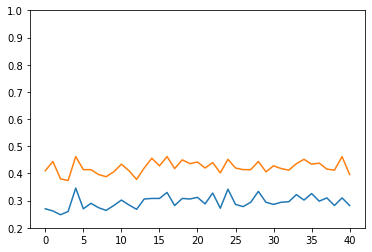

In [ ]:
dqn.train(50000,time_lim=10000)

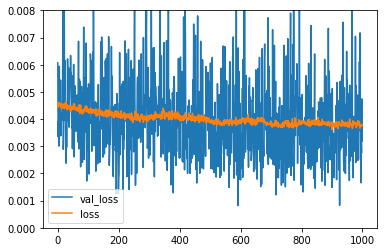

In [ ]:
plt.plot(dqn.val_loss_history)
plt.plot(dqn.loss_history)
plt.ylim(0,0.008)
plt.legend(['val_loss','loss'])

In [ ]:
min(dqn.loss_history)

0.003616419804166071

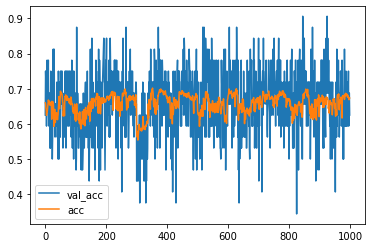

In [ ]:
plt.plot(dqn.val_acc_history)
plt.plot(dqn.acc_history)
plt.legend(['val_acc','acc'])

In [ ]:
dqn.test()

[0.842, 0.914]